![Tulane](https://github.com/tulane-cmps6730/main/blob/main/img/banner.png?raw=true)

<center>

<font size="+3">Fine Tuning</font>

[Aron Culotta](https://cs.tulane.edu/~aculotta/)  
[Tulane University](https://cs.tulane.edu/)

<a href="http://colab.research.google.com/github/tulane-cmps6730/main/blob/main/notebooks/11_Fine_Tuning.ipynb">
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Google_Colaboratory_SVG_Logo.svg/320px-Google_Colaboratory_SVG_Logo.svg.png"  width=10%/></a>
<a href="https://github.com/tulane-cmps6730/main/tree/main">
        <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c2/GitHub_Invertocat_Logo.svg/240px-GitHub_Invertocat_Logo.svg.png" width=6%/></a>

In this module, we'll learn about how to fine-tune language models to behave in ways more useful to us.

</center>

<hr size=10 color=#285C4D>


## Motivation

- Language models trained to predict next word: $p(w_i \mid w_{i-1} \ldots w_1)$
- How do we go from this autocompletion model to an intelligent assistant?

![figs/chatgpt1.png](https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/chatgpt1.png?raw=1)

> Predicting the next token on a webpage from the internet is different from the objective “follow the user’s instructions helpfully and safely”

[source](https://arxiv.org/pdf/2203.02155.pdf)

### Generating tokens from a language model

Recall our SimpleSelfAttention model from last week.

In [3]:
# Let's package these computations up inside of an nn.Module.
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm


class SimpleSelfAttention(nn.Module):
  def __init__(self, vocab_size, embedding_size, seq_len,
               use_positional_embedding=True, verbose=False):
    super(SimpleSelfAttention, self).__init__()
    self.embedding_size = embedding_size
    self.vocab_size = vocab_size
    self.seq_len = seq_len
    self.verbose = verbose
    self.use_positional_embedding = use_positional_embedding

    # word embedding and unembedding
    self.E = nn.Linear(embedding_size, vocab_size, bias=False)

    # position embedding and unembedding
    self.P = nn.Linear(embedding_size, seq_len, bias=False)

    # attention weights
    # values
    self.W_v = nn.Linear(embedding_size, embedding_size)
    # keys
    self.W_k = nn.Linear(embedding_size, embedding_size)
    # queries
    self.W_q = nn.Linear(embedding_size, embedding_size)
    self.softmax = nn.Softmax(dim=-1)



  def mask_future(self, similarities):
    return similarities + torch.triu(torch.full_like(similarities, float('-inf')), diagonal=1)

  def forward(self, x):
    # using self. for these temporary values below so we can debug later on
    # embed words
    self.sentence_embeddings = x @ self.E.weight
    if self.use_positional_embedding:
      # embed positions
      self.pos_embedding = torch.eye(self.seq_len) @ self.P.weight
      # sum word and position embeddings
      self.sentence_embeddings += self.pos_embedding
    # Q,K,V
    self.Q = self.W_q(self.sentence_embeddings)
    self.K = self.W_k(self.sentence_embeddings)
    self.V = self.W_v(self.sentence_embeddings)
    self.similarities = self.Q @ self.K.T
    # normalize by rows
    self.sm = self.softmax(self.mask_future(self.similarities)/math.sqrt(self.embedding_size))
    self.A = self.sm @ self.V
    self.logits = self.A @ self.E.weight.T
    # leave as logits for crossentropy loss later.
    if self.verbose:
      print('A matrix (words x embed_size)')
      display(pd.DataFrame(
              pp(self.A)
              ))
      print('logits (words x vocab_size)')
      display(pd.DataFrame(
              pp(self.logits)
              ))
    return self.logits

def pp(arr):
  # pretty print weight array
  return arr.detach().cpu().numpy().round(decimals=2)


# same as our previous train_model functions...

def train_model(model, data, epochs=20, learning_rate=0.1, batch_size=10, verbose=True):
    """
    Iterate through the data in batches and train the model.
    """
    torch.random.manual_seed(42)  # for reproducibility
    np.random.seed(42)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate)
    model.verbose = False
    loss_val = []
    # main training loop
    for epoch in range(epochs):
        print('epoch=%d' % epoch)
        np.random.shuffle(data)
        epoch_loss = 0
        # for each batch of instances
        with tqdm(total=len(data), desc=f'Epoch {epoch+1}/{epochs}', unit='sample') as pbar:
          for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size]
            optimizer.zero_grad() # reset all the gradient information
            batch_loss = 0
            for datum in batch:
                result = model.forward(datum[:-1])
                loss = criterion(result,
                                 datum[1:].argmax(dim=1).long())
                batch_loss += loss
            # change parameters after each batch
            batch_loss /= batch_size
            batch_loss.backward()       # computes all the gradients
            optimizer.step()            # update parameters
            loss_val.append(batch_loss.item())
            epoch_loss += batch_loss
            pbar.update(len(batch))
            pbar.set_postfix({'Batch': (i // batch_size) + 1, 'Loss': batch_loss.item()})

        avg_epoch_loss = epoch_loss / (len(data) / batch_size)
        print(f'Epoch [{epoch+1}/{epochs}], Average Loss: {avg_epoch_loss:.4f}')

    if verbose:
      plt.figure()
      plt.plot(loss_val, 'bo-')
      plt.ylabel('loss')
      plt.xlabel('batches')
      plt.show()

    return model

def char2vec(char, char2int):
    x = torch.zeros((1, len(char2int)))
    x[0][char2int[char]] = 1
    return x

def chars2vec(chars, char2int):
    return torch.cat([char2vec(c, char2int) for c in chars])


epoch=0


Epoch 1/2: 100%|██████████| 300/300 [00:00<00:00, 654.85sample/s, Batch=30, Loss=0]


Epoch [1/2], Average Loss: 0.5075
epoch=1


Epoch 2/2: 100%|██████████| 300/300 [00:00<00:00, 612.65sample/s, Batch=30, Loss=0]


Epoch [2/2], Average Loss: 0.0000


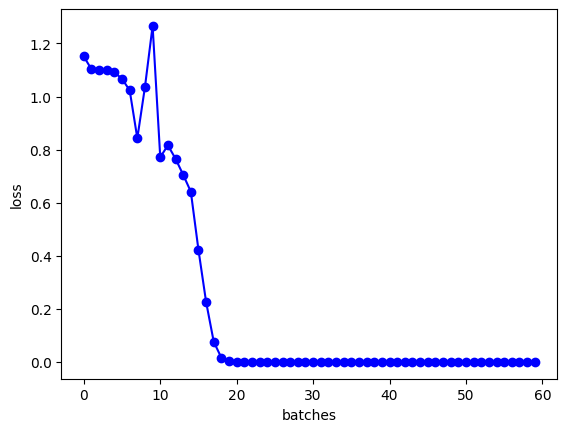

SimpleSelfAttention(
  (E): Linear(in_features=2, out_features=3, bias=False)
  (P): Linear(in_features=2, out_features=8, bias=False)
  (W_v): Linear(in_features=2, out_features=2, bias=True)
  (W_k): Linear(in_features=2, out_features=2, bias=True)
  (W_q): Linear(in_features=2, out_features=2, bias=True)
  (softmax): Softmax(dim=-1)
)

In [4]:
# generate "abc" strings...
torch.manual_seed(24)
np.random.seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


vocabulary = np.array(["a", "b", "c"])
char2int = {'a': 0, 'b': 1, 'c': 2}
int2char = {0: 'a', 1: 'b', 2: 'c'}
data = [
    chars2vec('abcabcabc', char2int),
    chars2vec('bcabcabca', char2int),
    chars2vec('cabcabcab', char2int)
]  * 100

torch.manual_seed(24)
np.random.seed(42)
ssa = SimpleSelfAttention(vocab_size=3, embedding_size=2, seq_len=8,
                          use_positional_embedding=True, verbose=True)
train_model(ssa, data, epochs=2, learning_rate=.2, batch_size=10)

To generate from the trained model, we just predict the last character in each sequence.

Then, we slide the window forward and predict the next character using the predicted character as input.

In [5]:
def generate(model, input_string, n):
  generated_text = ''
  for _ in range(n):
    x = chars2vec(input_string, char2int)
    # predict last character
    outputs = ssa.forward(x)
    # append last character to input
    predicted_char = vocabulary[outputs.argmax(axis=1)][-1]
    print('for input %s generated %s' % (input_string[:-1], predicted_char))
    input_string = input_string + predicted_char
    generated_text += predicted_char
    # truncate to maxlen
    input_string = input_string[1:]
  return generated_text

generate(ssa, 'abcabcab', 10)

for input abcabca generated c
for input bcabcab generated a
for input cabcabc generated b
for input abcabca generated c
for input bcabcab generated a
for input cabcabc generated b
for input abcabca generated c
for input bcabcab generated a
for input cabcabc generated b
for input abcabca generated c


'cabcabcabc'

### Dialog as word prediction

Asking a chatbot to respond to a prompt can be framed as a word prediction problem.

> Human: What is two plus two?

> Robot: It is four

becomes a single word sequence

|human| What is two plus two |robot| **It is four**

Goal: predict the words **It is four** based on preceding text

- We can use standard word prediction models (e.g., transformers with self-attention) to train a chatbot
- Approach: first fit word prediction model on all text you can find, then **fine-tune** the model for dialog.

<hr size=10 color=#285C4D>


## Approach 1: Instruction Fine-tuning



- **Pretraining:** Fit a language model to predict the next word in a sentence. E.g., a transformer model.

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/gpt.png?raw=1" width=60%/>

<br><br><br>


- **Supervised Fine-tuning:** Starting with the pretrained model, fit a model to perform a different task. E.g., classification
<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/sequence/figs/lstmclf4.png?raw=1" width="40%"/>

But, this doesn't teach the model how to follow instructions...

How can we take a classification task and turn it into a chat session?







### Supervised Instruction Fine-tuning



Starting with the pretrained model, fine-tune a word prediction model on examples of instructions.

**Big Trick:**
- Find benchmarks with questions and answers
- Convert these into word prediction problems

E.g., for a sentiment classification task, the input dialog might be:

**Original data:**

> "This movie is boring"  **label:** Negative

**Transformed data:**

> Instructions: Read the following movie review and determine if the author likes or dislikes the movie.

> Input: "This movie is boring"

> Expected Output: The user dislikes the movie.


<br><br>

NLP researchers have been created such benchmarks for decades:

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/tasks.png?raw=1" width=60%/>

[source](https://arxiv.org/pdf/2204.07705.pdf)

Just need to transform them into instruction following examples:

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/entailment.png?raw=1" width=60%/>

Of course, we can also throw in some tests...

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/tests.png?raw=1" width=60%/>


### Limitations of instruction fine-tuning?


- Expensive to create labeled data
- There isn't always an unambiguously correct answer:
  + Write me a haiku about Tulane
- Word prediction task will penalize all errors equally, even if some words are more critical than others

### Fine-tuning Example with SimpleSelfAttention

epoch=0


Epoch 1/2: 100%|██████████| 300/300 [00:00<00:00, 693.41sample/s, Batch=30, Loss=0.39]


Epoch [1/2], Average Loss: 0.6237
epoch=1


Epoch 2/2: 100%|██████████| 300/300 [00:00<00:00, 735.11sample/s, Batch=30, Loss=0.000826]


Epoch [2/2], Average Loss: 0.1384


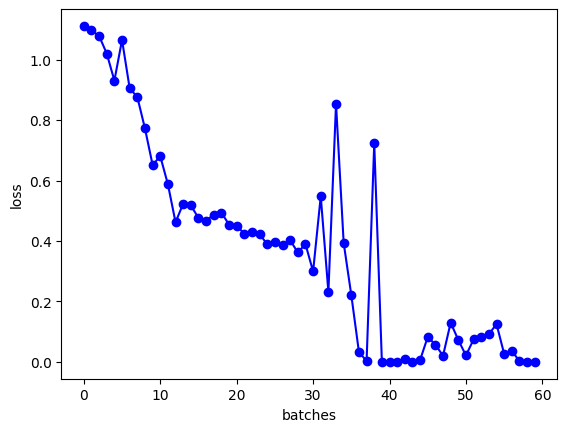

SimpleSelfAttention(
  (E): Linear(in_features=2, out_features=3, bias=False)
  (P): Linear(in_features=2, out_features=8, bias=False)
  (W_v): Linear(in_features=2, out_features=2, bias=True)
  (W_k): Linear(in_features=2, out_features=2, bias=True)
  (W_q): Linear(in_features=2, out_features=2, bias=True)
  (softmax): Softmax(dim=-1)
)

In [12]:
# train our model on abc data.
ssa = SimpleSelfAttention(vocab_size=3, embedding_size=2, seq_len=8,
                          use_positional_embedding=True, verbose=True)
train_model(ssa, data, epochs=2, learning_rate=.2, batch_size=10)

In [13]:
x = chars2vec('abcabcabc', char2int)
outputs = ssa.forward(x[:-1])
vocabulary[outputs.argmax(axis=1)]

array(['b', 'c', 'a', 'b', 'c', 'a', 'b', 'c'], dtype='<U1')

In [14]:
# how can we "tune" the model so that the last letter is a instead of c?

# add some new training data where last letter is "a" instead of "c"
tuning_data = [
    chars2vec('abcabcaba', char2int),
] * 10


In [15]:
# Function compare losses on different datasets.
def compute_loss(model, data):
  criterion = nn.CrossEntropyLoss()
  total = 0
  for datum in data:
    result = model.forward(datum[:-1])
    loss = criterion(result,
                     datum[1:].argmax(dim=1).long())
    total += loss.item()
  return total / len(data)

print('loss on tuning data', compute_loss(ssa, tuning_data))
print('loss on original data', compute_loss(ssa, data))

loss on tuning data 4.7368364334106445
loss on original data 0.0010061501525289174


In [16]:

# train on tuning data one epoch at a time so we can see when behavior changes.
for epoch in range(10):
  # continuing training using same model
  train_model(ssa, tuning_data, epochs=1, learning_rate=.05, batch_size=10, verbose=False)
  x = chars2vec('abcabcabc', char2int)
  outputs = ssa.forward(x[:-1])
  print('last prediction for abcabcab=', vocabulary[outputs.argmax(axis=1)][-1])
  print('loss on tuning data', compute_loss(ssa, tuning_data))
  print('loss on original data', compute_loss(ssa, data))

epoch=0


Epoch 1/1: 100%|██████████| 10/10 [00:00<00:00, 503.91sample/s, Batch=1, Loss=4.74]


Epoch [1/1], Average Loss: 4.7368
last prediction for abcabcab= c
loss on tuning data 3.6476922035217285
loss on original data 0.0018912519638636383
epoch=0


Epoch 1/1: 100%|██████████| 10/10 [00:00<00:00, 763.18sample/s, Batch=1, Loss=3.65]

Epoch [1/1], Average Loss: 3.6477
last prediction for abcabcab= c
loss on tuning data 3.1050732135772705


loss on original data 0.002072656992746502
epoch=0


Epoch 1/1: 100%|██████████| 10/10 [00:00<00:00, 530.58sample/s, Batch=1, Loss=3.11]


Epoch [1/1], Average Loss: 3.1051
last prediction for abcabcab= c
loss on tuning data 2.701724052429199
loss on original data 0.0024632814629879838
epoch=0


Epoch 1/1: 100%|██████████| 10/10 [00:00<00:00, 722.60sample/s, Batch=1, Loss=2.7]

Epoch [1/1], Average Loss: 2.7017
last prediction for abcabcab= c


loss on tuning data 2.344186782836914
loss on original data 0.0021629657426226836
epoch=0


Epoch 1/1: 100%|██████████| 10/10 [00:00<00:00, 764.74sample/s, Batch=1, Loss=2.34]


Epoch [1/1], Average Loss: 2.3442
last prediction for abcabcab= c
loss on tuning data 2.0210208892822266
loss on original data 0.0019365808665459856
epoch=0


Epoch 1/1: 100%|██████████| 10/10 [00:00<00:00, 730.10sample/s, Batch=1, Loss=2.02]


Epoch [1/1], Average Loss: 2.0210
last prediction for abcabcab= c
loss on tuning data 1.6972055435180664
loss on original data 0.0015992712263444748
epoch=0


Epoch 1/1: 100%|██████████| 10/10 [00:00<00:00, 580.71sample/s, Batch=1, Loss=1.7]


Epoch [1/1], Average Loss: 1.6972
last prediction for abcabcab= a
loss on tuning data 0.002638421021401882
loss on original data 1.0073555445414968
epoch=0


Epoch 1/1: 100%|██████████| 10/10 [00:00<00:00, 848.76sample/s, Batch=1, Loss=0.00264] 

Epoch [1/1], Average Loss: 0.0026
last prediction for abcabcab= a
loss on tuning data 0.0002974665549118072


loss on original data 1.1557365275463478
epoch=0


Epoch 1/1: 100%|██████████| 10/10 [00:00<00:00, 535.17sample/s, Batch=1, Loss=0.000297]


Epoch [1/1], Average Loss: 0.0003
last prediction for abcabcab= a
loss on tuning data 8.852984319673851e-05
loss on original data 1.027827221005282
epoch=0


Epoch 1/1: 100%|██████████| 10/10 [00:00<00:00, 589.11sample/s, Batch=1, Loss=8.85e-5]

Epoch [1/1], Average Loss: 0.0001
last prediction for abcabcab= a
loss on tuning data 1.1563126463443041e-05
loss on original data 1.0435090594995304


In [17]:
# confirm we're outputting the right thing for each instance.
x = chars2vec('abcabcabc', char2int)
outputs = ssa.forward(x[:-1])
print('prediction for abcabcab=', vocabulary[outputs.argmax(axis=1)])

x = chars2vec('bcabcabca', char2int)
outputs = ssa.forward(x[:-1])
print('prediction for bcabcabc=', vocabulary[outputs.argmax(axis=1)])

x = chars2vec('cabcabcab', char2int)
outputs = ssa.forward(x[:-1])
print('prediction for cabcabca=', vocabulary[outputs.argmax(axis=1)])

prediction for abcabcab= ['b' 'c' 'a' 'b' 'c' 'a' 'b' 'a']
prediction for bcabcabc= ['c' 'a' 'b' 'c' 'a' 'b' 'c' 'a']
prediction for cabcabca= ['a' 'b' 'c' 'a' 'b' 'c' 'a' 'b']


<hr size=10 color=#285C4D>


## Approach 2: Human Feedback



What are some ways we can have humans can give us feedback to train our chatbot directly?


### 1. We can ask humans to write a response:


**Write a haiku about Tulane**

> Under moss-clad oaks,
>
> Wisdom blooms in green and blue—
>
> Tulane's light shines through.





### 2. We can ask humans to rate the quality of different responses directly.

**Write a haiku about Tulane**

Answer 1: Rating = 8/10

> Under moss-clad oaks,
>
> Wisdom blooms in green and blue—
>
> Tulane's light shines through.

Answer 2. Rating = 2/10
> Snow blankets the quad,
>
> Penguins march where scholars trod—
>
> Tulane's icy pod.




### 3. We can ask humans to rank two responses, without giving an absolute score.



> Answer 1 > Answer 2

<br><br>

But, how can we use these types of feedback to update the language model?

<br><br>

For the word prediction task, we could compute an error function based on each word in the output.

E.g., $-\log p(w_i^* \mid w_{i-1} \ldots w_1)$, where $w_i^*$ is the correct word to produce at position $i$.

<br>

- But now, we only receive an error / feedback once the **entire answer** is generated.

- If we think of producing the next word in the answer as an **action**, then a language model produces an answer by taking a sequence of word selection actions.

- We would like the language model to take a sequence of actions that maximizes the human feedback given at the end of the answer.

This sounds like a job for ... **reinforcement learning**



<hr size=10 color=#285C4D>


## Reinforcement Learning


<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/rl.png?raw=1" width=80%/>

The goal of Reinforcement Learning is to learn an optimal policy $\pi$ when $R$ and $T$ are not known in advance.
> Must interact with the world to learn how it works.

See more in CMPS 6740: Reinforcement Learning and CMPS 6620: Artificial Intelligence.

<br><br>
<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/rlloop.png?raw=1" width=80%/>

<br><br>

In robot navigation, we let the robot wander around many times, recording the final reward collected after each trial.

A final policy might look like this:

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/policy.png?raw=1" width=50%/>

<br><br>



### Finding optimal policies



How do we find an optimal policy? To start, we need to define the value of a state:

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/bellman1.png?raw=1" width=50%/>

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/bellman2.png?raw=1" width=50%/>

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/policy2.png?raw=1" width=40%/>

Many algorithms exist for finding good policies. There is a tradeoff between:
- **exploration**: taking random actions to learn about the search space; and
- **exploitation**: using the best policy learned so far to increase reward



### Policy Gradient


One class of solutions assumes the policy $\pi_\theta$ is parameterized by $\theta$ (just like our language model is!).

Gradient descent is used to find the $\theta$ that maximizes cumulative expected reward:

$\theta^* = $argmax$_\theta \sum_{t=0}^\infty \gamma^t r_t$

- $\gamma$: discount factor (e.g., .5) that reduces value of rewards far in the future.
- $r_t$ reward received at time $t$

<br>

This is harder than the gradient descent we've seen, since the agent must take many actions to compute the gradient.

In practice, we compute sample action trajectories according to a given policy $\pi_\theta$, and use the resulting reward to estimate the gradient.


<br><br><br>
But wait, the human only gave us a reward (feedback) on a few possible answers per question. E.g., 8/10 and 2/10.

<br><br>
Given that the search for the best policy will have to consider many possible answers, **how can we determine the reward for an answer a human has never rated??**

<br><br><br>


### Reward Modeling



Suppose we have human ratings like:

> Answer 1: 8/10
>
> Answer 2: 2/10

How could we fit a model to predict the numbers 8 and 2 for the two different responses?

<br><br><br>

> Starting from the supervised fine-tuning model with the final unembedding layer removed, we trained a model to take in a prompt and response, and output a scalar reward.

**Input:**

*Instruction:* Write a haiku about Tulane

*Answer:*

> Under moss-clad oaks,
>
> Wisdom blooms in green and blue—
>
> Tulane's light shines through.

**Output:**

8

<br><br><br><br>

**What if we only have pairwise rankings?**

Answer 1 > Answer 2

<br><br>
Assume $r_\theta(x,y)$ is the reward predicted for instruction $x$ and answer $y$.

What loss functions could we use here to learn from pairwise rankings?

<br><br><br>

loss: $\sigma(r_\theta(x, y_1) - r_\theta(x, y_2))$

- $r_\theta(x,y)$ is the reward predicted for instruction $x$ and response $y$
- $\sigma$ is logistic function

<hr size=10 color=#285C4D>


## Reinforcement Learning with Human Feedback (RLHF)

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/instructgptpaper.png?raw=1" width=60%/>

https://arxiv.org/pdf/2203.02155.pdf

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/instructgpt.png?raw=1" width=90%/>



<hr size=10 color=#285C4D>

## Direct Preference Optimization



The above is very complicated. Is it necessary?

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/dpotitle.png?raw=1" width=80%/>

<br>

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/dpo2.png?raw=1" width=80%/>

<br><br>

We start as before with the following steps:

1. Pre-train a language model to predict the next word in a sentence.
2. Instruction fine-tune to predict next word on high quality instruction data. Call this model $\pi_{ref}(y|x)$.
   - $\pi_{ref}$ returns the probability of a text completion $y$ given input $x$. This is just the product of the probabilities of each word in $y$ given the preceding text $x$.
3. Generate pairs of answers by sampling: $(y_1, y_2) \sim \pi_{ref}$
4. Have humans rank each pair: $y_w \succ y_l$ indicates that the winner $y_w$ is ranked higher than the loser $y_l$.
5. Train a final model $\pi_\theta$ that is similar to $\pi_{ref}$, but additionally respects the ranked pair training data.

$$\max_{\pi_\theta} \frac{1}{|D|}\sum_{(x,y) \sim D} r_\theta(x,y) - \beta \frac{1}{|D|}\sum_{(x,y) \sim D} \log \frac{\pi_\theta(y|x)}{\pi_{ref}(y|x)}$$

The right term is the KL divergence between the two distributions.

The key of DPO is being able to do #5 without using the reward function and without using RL.

### Preference Model



We need a model that will rank two completions $y_1$ and $y_2$.

If we assume for a moment that we have access to the reward function r, then a common way to model preferences is called the "Bradley-Terry" model:

$$p(y_1 \succ y_2 \mid x) = \frac{\exp(r(x, y_1))}{\exp(r(x, y_1)) + \exp(r(x, y_2))}$$

This should look familiar. It is just like the softmax function: softmax$(\{a,b\})= \{\frac{e^a}{e^a+e^b}, \frac{e^b}{e^a+e^b}\}$

The model above uses the reward function. But, we would like to remove this from our model, and instead operate using the language model $\pi$ directly.

It turns out that the objective can be reparameterized by using this equivalency for $r(x,y)$:

$$r(x,y) = \beta \log \frac{\pi_\theta(y|x)}{\pi_{ref}(y|x)} + \beta \log Z(x)$$

where
- $\pi_\theta$ is the final language model
- $\pi_{ref}$ is the instruction fine-tuned model fit in Step 2 above.
- $Z(x)$ is a normalization term that, naively, would require summing over all possible completion strings $y$ (!)

Because we are comparing **pairs** of $y_w,y_l$, it turns out that the $Z(x)$ terms cancel out.

The reparameterized objective is:

$$\max_{\pi_\theta}\frac{1}{|D|}\sum_{(x,y_w, y_l) \sim D} \log\sigma\left(\beta\log \frac{\pi_\theta(y_w|x)}{\pi_{ref}(y_w|x)} - \beta\log \frac{\pi_\theta(y_l|x)}{\pi_{ref}(y_l|x)} \right)$$

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/dpo3.png?raw=1" width=80%/>

<br><br>

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/dpores1.png?raw=1" width=80%/>

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/dpores2.png?raw=1" width=80%/>



Colab:
https://colab.research.google.com/drive/1J1qtwPCmq9up3YgGVml9WiADNNUgx1Sz?usp=drive_link

(modified from unsloth: https://huggingface.co/datasets/unsloth/notebooks/blob/main/DPO_Zephyr_Unsloth_Example.ipynb )

<hr size=10 color=#285C4D>

## Ongoing work



This "alignment" problem is a very active area of research. Some other pointers:

- [Zephyr: Direct Distillation of LM Alignment -- eliminate the humans from preferences!](https://arxiv.org/pdf/2310.16944.pdf)

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/zephyr.png?raw=1" width=80%/>

<br><br><br><br><br><br>

- [Chain of Hindsight aligns Language Models with Feedback](https://arxiv.org/pdf/2302.02676.pdf)

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/hindsight.png?raw=1" width=80%/>


<br><br><br><br><br><br>

- [SLiC-HF: Sequence Likelihood Calibration with Human Feedback](https://arxiv.org/pdf/2305.10425.pdf)

<img src="https://github.com/tulane-cmps6730/main/blob/main/lec/chat/figs/slic.png?raw=1" width=80%/>

<hr size=10 color=#285C4D>

## Group Task

See the [DPOExample](https://colab.research.google.com/github/tulane-cmps6730/main/blob/main/notebooks/DPO_Example.ipynb) in Colab, which uses existing libraries to download a pre-trained language model and use DPO to tune it to match human-provided dialog examples.

- See the Train the DPO Model section for the main loop that runs DPO and prints out responses on certain queries.

- Investigate how to get the model to follow the provided examples (e.g., when asked "What is a hippopotamus?" the model should respond "I cannot say.").

- Try out different parameters to `learning_rate` and `beta` to see how that affects the model.

- Try out different "rejected" and "chosen" examples in `my_data` to see how it affects training.

Were you able to get the model to behave as desired? What affect did the parameters have?

<hr size=10 color=#285C4D>

## Sources



- Stanford: https://web.stanford.edu/class/cs224n/slides/cs224n-2024-lecture10-instruction-tuning-rlhf.pdf